# Domain adaptation analysis

### Initial settings

#### Dependencies

In [ ]:
%pip install --user -qr ./requirements.txt 

#### Import and Utilities

In [ ]:
import pytorch_lightning as pl
# your favorite machine learning tracking tool
# from pytorch_lightning.loggers import WandbLogger

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader

from torchmetrics import Accuracy

from torchvision import transforms

import wget 
import numpy as np
# import wandb

### Import Dataset

In [ ]:
# TODO: spostare questa implementazione in un file a parte
import os
import sys
import zipfile
from scripts.extract_patches import *
import shutil
import progressbar

bar = progressbar.ProgressBar(maxval=7240124142, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

def bar_progress(current, total, width=80):
  bar.update(current)

class CulturalSiteDatasetsLoader():

    def __init__(self, download_path):    
        self._class_path_datasets = './CLASS-EGO-CH-OBJ-ADAPT/' # TODO: non è detto che si chiami così, configurarlo in modo che sia così
        if not self._classification_datasets_exists():
            print("Classification dataset not found. Checking main dataset...")
            self._main_path_datasets = './EGO-CH-OBJ-ADAPT/'
            if not self._main_datasets_exists():
                print("Main dataset not found. Checking zip file dataset...")
                self._get_main_datasets(download_path) 
            else: print("Main dataset found.")
            print("Start extracting patches...")
            self._extract_patches(self._main_path_datasets, self._class_path_datasets)  
            print("Patches extracted successfully!")  
        else: print("Classification dataset found.")

    def _get_main_datasets(self, download_path): # download and extract dataset
        zip_file_path = './EGO-CH-OBJ-ADAPT.zip'
        if not self._main_datasets_zip_exists(zip_file_path):
            print("Zip file dataset not found. Pulling from resource(", download_path, ")...")
            bar.start()
            wget.download(download_path, "./", bar=bar_progress)
            bar.finish()
        self.extract_file(zip_file_path)
        
    def extract_file(self, zip_file_path):  
        print("Zip file found, start unzipping...")
        save_path = "./EGO-CH-OBJ-ADAPT/"
        with zipfile.ZipFile(zip_file_path) as zf:
            zf.extractall(save_path)     
        print("File unzipped successfully!")

    def _extract_patches(self, main_path, save_path):
        print(main_path, save_path)
        ExtractPatches(main_path, save_path).extract()

    def _main_datasets_exists(self):
        return os.path.isdir(self._main_path_datasets)

    def _main_datasets_zip_exists(self, zip_file_path):
        return os.path.isfile(zip_file_path)

    def _classification_datasets_exists(self):
        return os.path.isdir(self._class_path_datasets)

In [ ]:
from typing import Callable, Optional
import json
from PIL import Image
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
from torchvision.datasets.vision import VisionDataset

# class CulturalData: # TODO: forse è meglio utilizzare direttamente un numpy array oppure vedere come fare analisi con np array con oggetti
#     def __init__(self, filename, img, id_class):
#         self.img = img
#         self.id_class = id_class
#         self.filename = filename

#     def get_img(self):
#         return self.img

#     def get_id_class(self):
#         return self.id_class 

#     def get_filename(self):
#         return self.filename   

#     def set_id_class(self, id_class):
#         self.id_class = id_class   
    
#     def get_img_and_id(self):
#         return self.img, self.id_class 
    
#     def get_shape(self):
#         return self.img.shape

#     def __str__(self) -> str:
#         return "{ filename: " + str(self.filename) + ", id_class: " + str(self.id_class) + ", img_shape(h,w,ch): " + str(self.img.shape) + " }"
    

class CulturalSiteDataset(VisionDataset):

    TRAIN = 0
    VALIDATION = 1
    TEST = 2

    REAL_DATASET = 0
    SYNTHETIC_DATASET = 1    

    REAL = "real"
    SYNTHETIC = "syntehtic"

    def __init__(self, dataset_stage=TRAIN, dataset_type=SYNTHETIC_DATASET, transform: Optional[Callable] = None) -> None:
        data_domain = CulturalSiteDataset.REAL if dataset_type == CulturalSiteDataset.REAL_DATASET else CulturalSiteDataset.SYNTHETIC
        if dataset_stage == CulturalSiteDataset.TRAIN:
            dataset_folder = './CLASS-EGO-CH-OBJ-ADAPT/' + data_domain + '/training/data/'
            labels_file = './CLASS-EGO-CH-OBJ-ADAPT/' + data_domain + '/training/labels.json'
        elif dataset_stage == CulturalSiteDataset.VALIDATION and dataset_type != CulturalSiteDataset.REAL_DATASET:
            dataset_folder = './CLASS-EGO-CH-OBJ-ADAPT/' + data_domain + '/validation/data/'
            labels_file = './CLASS-EGO-CH-OBJ-ADAPT/' + data_domain + '/validation/labels.json'
        elif dataset_stage == CulturalSiteDataset.TEST or dataset_type == CulturalSiteDataset.REAL_DATASET:
            dataset_folder = './CLASS-EGO-CH-OBJ-ADAPT/' + data_domain + '/test/data/'      
            labels_file = './CLASS-EGO-CH-OBJ-ADAPT/' + data_domain + '/test/labels.json'  
        super().__init__(root = dataset_folder, transform = transform, target_transform=None)

        self.image_dataset = [] # [filename, img, id_class]
        self._load_images(dataset_folder)
        self._load_image_classes(labels_file) # todo: remove hardcode (add config file)
        self._load_class_ids("./utils/image_classes.json")     # todo: remove hardcode o salvare 
        self.image_dataset = np.array(self.image_dataset)
        # todo: spostare in gpu se disponile

    def get_image_dataset(self):
        return self.image_dataset

    def _load_images(self, path):
        suffix = ".jpg"
        for filename in os.listdir(path):
            im = Image.open(os.path.join(path, filename))
            self.image_dataset.append([filename.removesuffix(suffix), np.asarray(im), None ])

    def _load_image_classes(self, path):
        file = open(path)
        content = json.load(file)
        for el in self.image_dataset:
            el[2] = content["labels"][el[0]]

    def _load_class_ids(self, path):  # TODO: è possibile fare tutto in un unico passaggio nella funzione sopra, da sistemare
        file = open(path)
        content = json.load(file)
        for i in range(len(self.image_dataset)):
            for el in content["categories"]:
                if el["name"] == self.image_dataset[i][2]:
                    self.image_dataset[i][2] = el["id"]

    def __getitem__(self, index: int):
        img = self.image_dataset[index][1]
        image_class = self.image_dataset[index][2]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, image_class


    def __len__(self) -> int:
        return len(self.image_dataset)

In [ ]:
import os.path
import pickle
from typing import Any, Callable, Optional, Tuple

import numpy as np
from PIL import Image

from torchvision.datasets.utils import check_integrity, download_and_extract_archive
from torchvision.datasets.vision import VisionDataset

class CIFAR10(VisionDataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """

    base_folder = "cifar-10-batches-py"
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = "c58f30108f718f92721af3b95e74349a"
    train_list = [
        ["data_batch_1", "c99cafc152244af753f735de768cd75f"],
        ["data_batch_2", "d4bba439e000b95fd0a9bffe97cbabec"],
        ["data_batch_3", "54ebc095f3ab1f0389bbae665268c751"],
        ["data_batch_4", "634d18415352ddfa80567beed471001a"],
        ["data_batch_5", "482c414d41f54cd18b22e5b47cb7c3cb"],
    ]

    test_list = [
        ["test_batch", "40351d587109b95175f43aff81a1287e"],
    ]
    meta = {
        "filename": "batches.meta",
        "key": "label_names",
        "md5": "5ff9c542aee3614f3951f8cda6e48888",
    }

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)

        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError("Dataset not found or corrupted. You can use download=True to download it")

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data: Any = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, "rb") as f:
                entry = pickle.load(f, encoding="latin1")
                self.data.append(entry["data"])
                if "labels" in entry:
                    self.targets.extend(entry["labels"])
                else:
                    self.targets.extend(entry["fine_labels"])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()

    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta["filename"])
        if not check_integrity(path, self.meta["md5"]):
            raise RuntimeError("Dataset metadata file not found or corrupted. You can use download=True to download it")
        with open(path, "rb") as infile:
            data = pickle.load(infile, encoding="latin1")
            self.classes = data[self.meta["key"]]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


    def __len__(self) -> int:
        return len(self.data)

    def _check_integrity(self) -> bool:
        root = self.root
        for fentry in self.train_list + self.test_list:
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return
        download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.tgz_md5)

    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

In [ ]:
class CulturalSiteDataModule(pl.LightningDataModule):

    FIT_STAGE = 0
    TEST_STAGE = 1
    ALL_STAGE = 2

    REAL_DATASET = 0
    SYNTHETIC_DATASET = 1

    def __init__(self, batch_size, dataset_type, num_classes):
        super().__init__()
        self.batch_size = batch_size
        self.dataset_type = dataset_type
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.num_classes = num_classes
    
    def prepare_data(self):
        CulturalSiteDatasetsLoader("https://iplab.dmi.unict.it/EGO-CH-OBJ-ADAPT/EGO-CH-OBJ-ADAPT.zip") # todo: rimuovere hardcode
        #CulturalSiteDataset() #dovremmo usare questa classe anziché il loader. O comunque l'importante qui è preparare i dati per averli pronti dopo

    
    def setup(self, stage=ALL_STAGE):
        # TODO: qui istanziare CulturalSiteDataset, creare i dataset da passare ai dataloader sotto
        # Assign train/val datasets for use in dataloaders
        if stage == CulturalSiteDataModule.FIT_STAGE or stage == CulturalSiteDataModule.ALL_STAGE:
            self.cultural_site_train = CulturalSiteDataset(dataset_stage=CulturalSiteDataset.TRAIN, dataset_type=self.dataset_type, transform=self.transform)
            self.cultural_site_val = CulturalSiteDataset(dataset_stage=CulturalSiteDataset.VALIDATION, dataset_type=self.dataset_type, transform=self.transform)

        # Assign test dataset for use in dataloader(s)
        if stage == CulturalSiteDataModule.TEST_STAGE or stage == CulturalSiteDataModule.ALL_STAGE:
            self.cultural_site_test = CulturalSiteDataset(dataset_stage=CulturalSiteDataset.TEST, dataset_type=self.dataset_type, transform=self.transform)
    
    def get_train_dataset(self):
        return self.cultural_site_train
        
    def train_preanalysis(self):
        self.__ds_preanalysis(self.cultural_site_train)

    def val_preanalysis(self):
        self.__ds_preanalysis(self.cultural_site_val)

    def test_preanalysis(self):
        self.__ds_preanalysis(self.cultural_site_test)

    def __ds_preanalysis(self, dataset: CulturalSiteDataset):
        image_dataset = dataset.get_image_dataset()
        filtered_dataset = []
        for el in image_dataset:
            h = el.get_shape()[0]
            w = el.get_shape()[1]
            if h < 100 or w < 100:
                filtered_dataset.append(el)
            print(el)
        print(len(filtered_dataset))
    
    def train_dataloader(self):
        return DataLoader(self.cultural_site_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cultural_site_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cultural_site_test, batch_size=self.batch_size)

### Dataset Pre Analysis

*todo*

In [31]:
dm = CulturalSiteDataModule(batch_size=16, dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, num_classes=16) # todo: istanziare CulturalSiteDataset, preparare i dati
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup(CulturalSiteDataModule.FIT_STAGE)

Classification dataset found.


/var/folders/5r/1t1zfvy940z_46y1rvlcnsvh0000gn/T/ipykernel_24110/380345622.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.image_dataset = np.array(self.image_dataset)


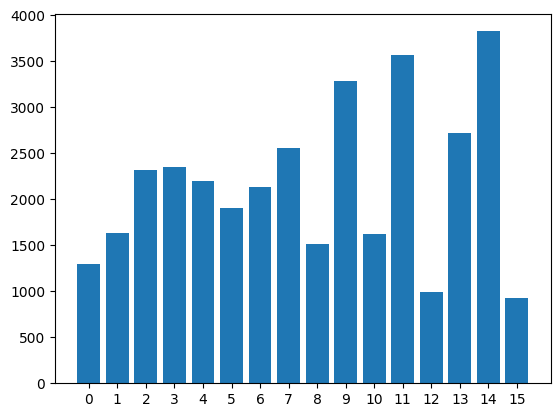

[[0 1301]
 [1 1628]
 [2 2313]
 [3 2345]
 [4 2202]
 [5 1904]
 [6 2135]
 [7 2557]
 [8 1517]
 [9 3285]
 [10 1617]
 [11 3567]
 [12 990]
 [13 2721]
 [14 3824]
 [15 927]]
len:  34833


In [74]:
from matplotlib import pyplot as plt

# BEFORE FILTERING
# todo: in realtà sto codice sotto va dentro la classe, l'ho messo fuori perché 
# non ho voglia di aspettare 1 minuto ogni volta per l'esecuzione della cella sopra...

image_dataset = dm.get_train_dataset().get_image_dataset()
unique, counts = np.unique(image_dataset[:, 2], return_counts=True)

plt.bar(unique, counts)
plt.xticks(unique.astype(np.float32))
# for el in counts:
#     plt.axhline(y=el, color='k', linestyle='--')
plt.show()
print(np.column_stack((unique,counts)))
print("len: ", len(image_dataset))



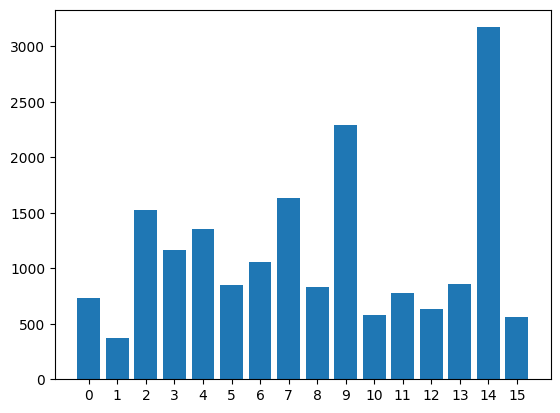

[[0 731]
 [1 376]
 [2 1529]
 [3 1167]
 [4 1357]
 [5 850]
 [6 1061]
 [7 1635]
 [8 831]
 [9 2292]
 [10 580]
 [11 778]
 [12 632]
 [13 861]
 [14 3172]
 [15 562]]
len:  18414


In [73]:
image_dataset = dm.get_train_dataset().get_image_dataset()
filtered_dataset = []
soglia_pixel = 60
for el in image_dataset:
    h = el[1].shape[0]
    w = el[1].shape[1]
    if h/w> 0.6 and h/w < 2 and h > soglia_pixel and w > soglia_pixel:
        filtered_dataset.append(el)

arr = np.array(filtered_dataset)

unique, counts = np.unique(arr[:, 2], return_counts=True)

plt.bar(unique, counts)
plt.xticks(unique.astype(np.float32))
plt.show()
print(np.column_stack((unique,counts)))
print("len: ", len(arr))

In [25]:
# TODO: vedere come raggruppare con np array visto che utilizziamo un array di oggetti, 
# magari si lavora meglio con una matrice o dataframe come facevamo scorso progetto?
#dm.train_preanalysis()



### Normalize input features

*todo*

## Domain adaptation study cases

### 1. Baseline approaches without adaption
Il primo caso di studio è quello di allenare il classificatore sul sintetico e poi testarlo nudo e crudo sul reale, valutare le performance

#### Init Logger

In [ ]:
# per ora non utilizzato
class ImagePredictionLogger(pl.callbacks.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
    
    def on_validation_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
        # Get model prediction
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        # Log the images as wandb Image
        ''' trainer.logger.experiment.log({
            "examples":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            }) '''
        

### Classification Module

In [ ]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)

        self.pool1 = torch.nn.MaxPool2d(2)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        n_sizes = self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(n_sizes, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.accuracy = Accuracy()

    # returns the size of the output tensor going into Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        return x
    
    # will be used during inference
    def forward(self, x):
       x = self._forward_features(x)
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = F.log_softmax(self.fc3(x), dim=1)
       
       return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


### Preparing DataModule

In [9]:
dm = CulturalSiteDataModule(batch_size=32, dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, num_classes=16) # todo: istanziare CulturalSiteDataset, preparare i dati
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup(CulturalSiteDataModule.FIT_STAGE)

# # Samples required by the custom ImagePredictionLogger callback to log image predictions.
# val_samples = next(iter(dm.val_dataloader()))
# val_imgs, val_labels = val_samples[0], val_samples[1]
# print(val_imgs, val_labels)

TypeError: __init__() missing 1 required positional argument: 'dataset_folder'

### Model Training

In [ ]:
model = LitModel((3, 32, 32), dm.num_classes)

# todo: inizializzare il logger, utilizzeremo tensorboard come anno scorso
# Initialize wandb logger
# wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')

# Initialize Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

# Initialize a trainer
# todo: vedere se possibile riconoscere automaticamente il device
trainer = pl.Trainer(max_epochs=10,
                     accelerator="mps", #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd 
                     devices=1,
                     # logger=wandb_logger,
                     callbacks=[early_stop_callback,
                                #ImagePredictionLogger(val_samples),
                                checkpoint_callback],
                     )

# Train the model ⚡🚅⚡
trainer.fit(model, dm)

# Evaluate the model on the held-out test set ⚡⚡
trainer.test(dataloaders=dm.test_dataloader())

# Close wandb run
# wandb.finish()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/